# Análisis espectral de microsismicidad y ruido ambiental para el canal de aceleración vertical (ENZ)

**Autor:** A. Isaac P.S.

**Fecha:** 2025-08-07

Este cuadernillo aplica **ObsPy** para importar y analizar sismicidad local grabada por la red de sismógrafos de SkyAlert en la Ciudad de México con el canal de aceleración vertical. Para ello, se calculan los **espectros de potencia** para **estimar la frecuencia de esquina** (*corner frequency, $f_c$*).
Con $f_c$ propondremos un **filtro** que maximice la resolución de la energía sísmica de los microsismos en nuestro flujo interno.


## 0. Objetivos
- Cargar una o varias trazas de velocidad en formato MiniSEED de algunos microsismos y señales de ruido de distinta naturaleza y duración.
- Pre-procesar los datos para eliminar la tendencia natural.
- Calcular espectros de amplitud/PSD usando la teoría de Fourier.
- A partir de un análisis cualitativo de los especogramas, **estimar la frecuencia de esquina $f_c$**.
- Proponer y probar un **filtro** (p.ej. banda/alto) en torno a $f_c$.
- Validar los resultados del filtro aplicando STA/LTA con los parámetros actuales del sistema de microsismos para los cuatro canales y contabilizar el número de falsas activaciones antes y despúes del filtro propuesto.
- Guardar figuras y resultados clave para su integración al sistema.


## 1. Instalación y librerías



In [4]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from scipy.signal import welch
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import pandas as pd

## 2. Carga de datos
Se trabaja con los siguientes eventos:
- Traza 1: M2.7 del 27 de septiembre de 2024 (R9837).
- Traza 2: M2.9 del 27 de septiembre de 2024 (RB52D).
- Traza 3: M2.0 del 7 de octubre de 2024 (R5FE1).
- Traza 4: M1.9 del 18 de noviembre de 2024 (RB604).
- Trazas 5 y 6: M1.9 del 18 de junio de 2025 (R03B7 y R9837).
- Trazas 7 y 8: M2.3 del 24 de junio de 2025 (R9837 y R03B7).
- Trazas 9 y 10: Trueno del 10 de agosto de 2025 (R88E8 y R8712).
- Trazas 11 y 12: Ruido del 25 de agosto de 2025 (RB604 y R03B7).


In [6]:
# Rutas de archivos MiniSEED
rutas = [
    "Corner Frequency/M27-27-sep-2024-R9837.mseed",
    "Corner Frequency/M29-27-sep-2024-RB52D.mseed",
    "Corner Frequency/M20-7-oct-2024-R5FE1.mseed",
    "Corner Frequency/M19-18-nov-2024-RB604.mseed",
    "Corner Frequency/M19-18-jun-2025-R03B7.mseed",
    "Corner Frequency/M19-18-jun-2025-R9837.mseed",
    "Corner Frequency/M23-24-jun-2025-R9837.mseed",
    "Corner Frequency/M23-24-jun-2025-R03B7.mseed",
    "Corner Frequency/Trueno-10-ago-2025-R88E8.mseed",
    "Corner Frequency/Trueno-10-ago-2025-R8712.mseed",
    "Corner Frequency/Ruido-25-ago-2025-RB604.mseed",
    "Corner Frequency/Ruido-25-ago-2025-R03B7.mseed"
]

# Leer y seleccionar canal ENZ
trazas = []
for ruta in rutas:
    st = read(ruta)
    st = st.select(channel="ENZ")  # seleccionar solo canal ENZ
    if len(st) > 0:
        tr = st[0]
        tr.detrend(type="simple")  # quitar tendencia
        trazas.append(tr)

In [7]:
trazas

[AM.R9837.00.ENZ | 2024-09-27T23:50:28.703000Z - 2024-09-27T23:53:30.613000Z | 100.0 Hz, 18192 samples,
 AM.RB52D.00.ENZ | 2024-09-27T09:55:58.978000Z - 2024-09-27T09:59:01.228000Z | 100.0 Hz, 18226 samples,
 AM.R5FE1.00.ENZ | 2024-10-07T21:40:58.587000Z - 2024-10-07T21:41:51.637000Z | 100.0 Hz, 5306 samples,
 AM.RB604.00.ENZ | 2024-09-18T08:01:08.691000Z - 2024-09-18T08:02:14.991000Z | 100.0 Hz, 6631 samples,
 AM.R03B7.00.ENZ | 2025-06-18T15:28:58.777000Z - 2025-06-18T15:30:31.867000Z | 100.0 Hz, 9310 samples,
 AM.R9837.00.ENZ | 2025-06-18T15:28:58.790000Z - 2025-06-18T15:30:31.270000Z | 100.0 Hz, 9249 samples,
 AM.R9837.00.ENZ | 2025-06-24T05:57:59.930000Z - 2025-06-24T05:59:40.210000Z | 100.0 Hz, 10029 samples,
 AM.R03B7.00.ENZ | 2025-06-24T05:57:59.797000Z - 2025-06-24T05:59:40.447000Z | 100.0 Hz, 10066 samples,
 AM.R88E8.00.ENZ | 2025-08-10T00:16:58.035000Z - 2025-08-10T00:20:00.045000Z | 100.0 Hz, 18202 samples,
 AM.R8712.00.ENZ | 2025-08-10T00:16:58.693000Z - 2025-08-10T00:20:01

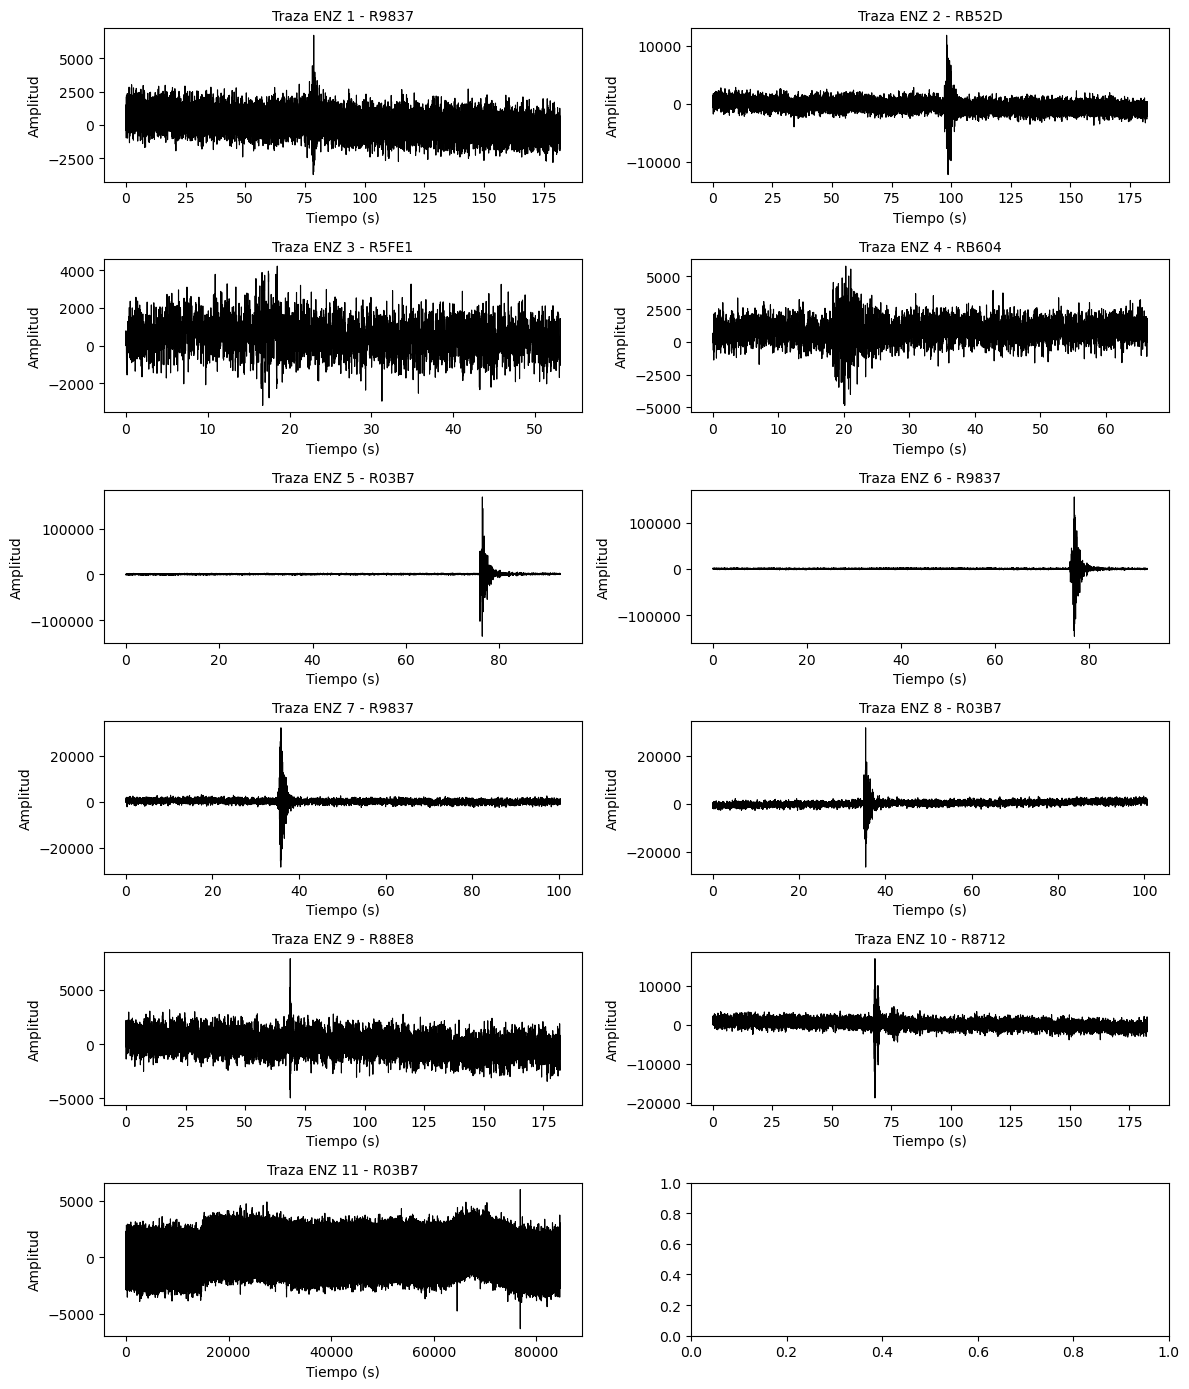

In [8]:
# Graficar todas las trazas
fig, axes = plt.subplots(6, 2, figsize=(12, 14))
axes = axes.flatten()

for i, tr in enumerate(trazas):
    t = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)
    axes[i].plot(t, tr.data, color="black", linewidth=0.8)
    axes[i].set_title(f"Traza ENZ {i+1} - {tr.stats.station}", fontsize=10)
    axes[i].set_xlabel("Tiempo (s)")
    axes[i].set_ylabel("Amplitud")

plt.tight_layout()
plt.show()



## 3. Espectros de potencia


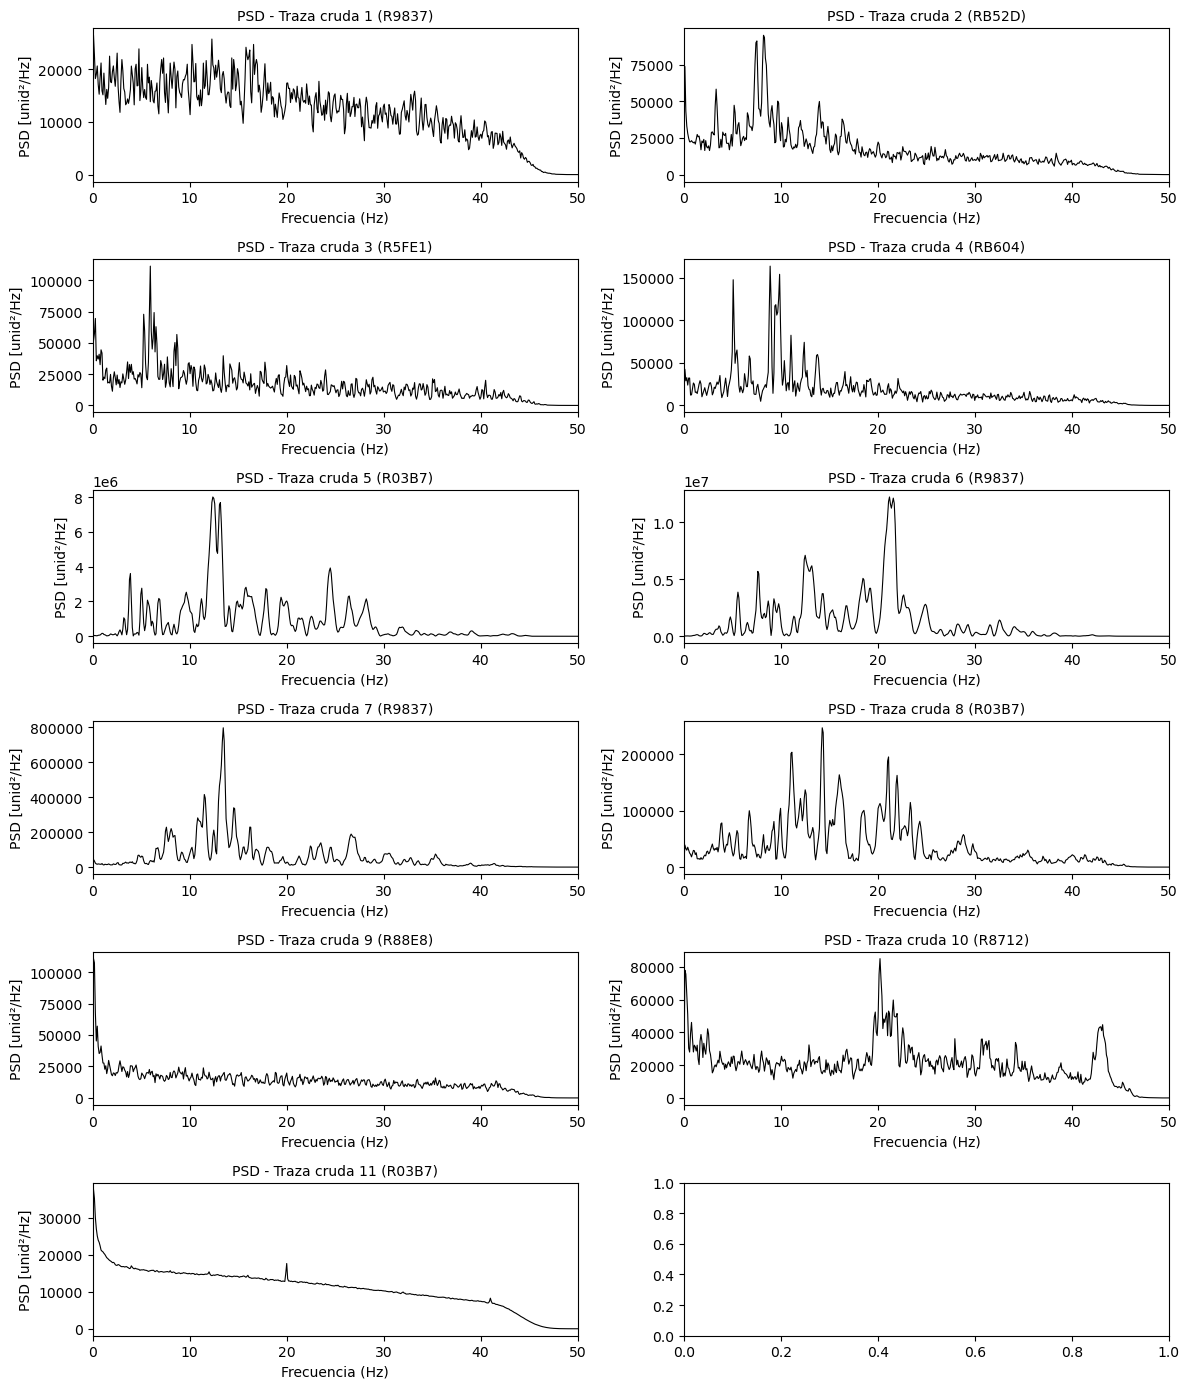

In [10]:
# Parámetros generales
# ----------------------------
fs = 100.0
fmax = fs/2  # 50 Hz
nperseg = 1024  # Welch

# Graficar espectros de potencia
fig, axes = plt.subplots(6, 2, figsize=(12, 14))
axes = axes.flatten()

for i, tr in enumerate(trazas):
    # Calcular espectro de potencia con Welch
    f, Pxx = welch(tr.data, fs=fs, nperseg=1024)
    # Graficar hasta Nyquist
    axes[i].plot(f, Pxx, color="black", linewidth=0.8)
    axes[i].set_xlim(0, fmax)
    axes[i].set_title(f"PSD - Traza cruda {i+1} ({tr.stats.station})", fontsize=10)
    axes[i].set_xlabel("Frecuencia (Hz)")
    axes[i].set_ylabel("PSD [unid²/Hz]")

plt.tight_layout()
plt.show()


## 4. Análisis cualitativo de los espectros de potencia (señales crudas)

### Microsismos (Trazas 1 a 8)
El contenido espectral de los microsismos analizados se distribuye principalmente entre **0.5 y 41 Hz**, presentando **picos de mayor potencia entre 7 y 14 Hz**.  

---

### Trueno (Trazas 9 y 10)
El contenido espectral de estos eventos resulta más **variable** y depende principalmente de la **cercanía de la fuente** respecto a la estación sísmica.  

- **Traza 9**: corresponde a la estación más distante. Su señal es demasiado débil en aceleración y no se distingue del ruido normal de fondo.  

- **Traza 10**: tiene un contenido espectral de banda ancha donde su mayor concentración de energía se da al rededor de los 20 Hz.

---

### Ruido ambiental de 24 horas (Trazas 11)
Las trazas de ruido normal muestran un comportamiento **altamente variable**, tanto en amplitud como en la forma y rango del espectro. Se observa un **pico de energía predominante cercano a 1 Hz**, atribuido a la **respuesta instrumental**, **respuesta del suelo local** y/o al **tipo de construcción** sobre la cual se instaló el instrumento. También se observaron **eventos aleatorios e impredecibles** que generan vibraciones transitorias de baja energía. Por ejemplo, pequeños picos en los 20 y 42 Hz.

---

## Conclusiones preliminares
Como primera aproximación, se propone la aplicación de un **filtro pasa bandas de tercer orden con frecuencia de corte mínima y máxima de 1 y 22 Hz, respectivamente**, con el objetivo de atenuar el ruido asociado a:

- Ruido de fondo.
- Actividad antropogénica (paso vehicular y peatonal),
- Fuentes atmosféricas (truenos),
- Otras vibraciones impulsivas de corta duración.  


## 4. Aplicación del filtro



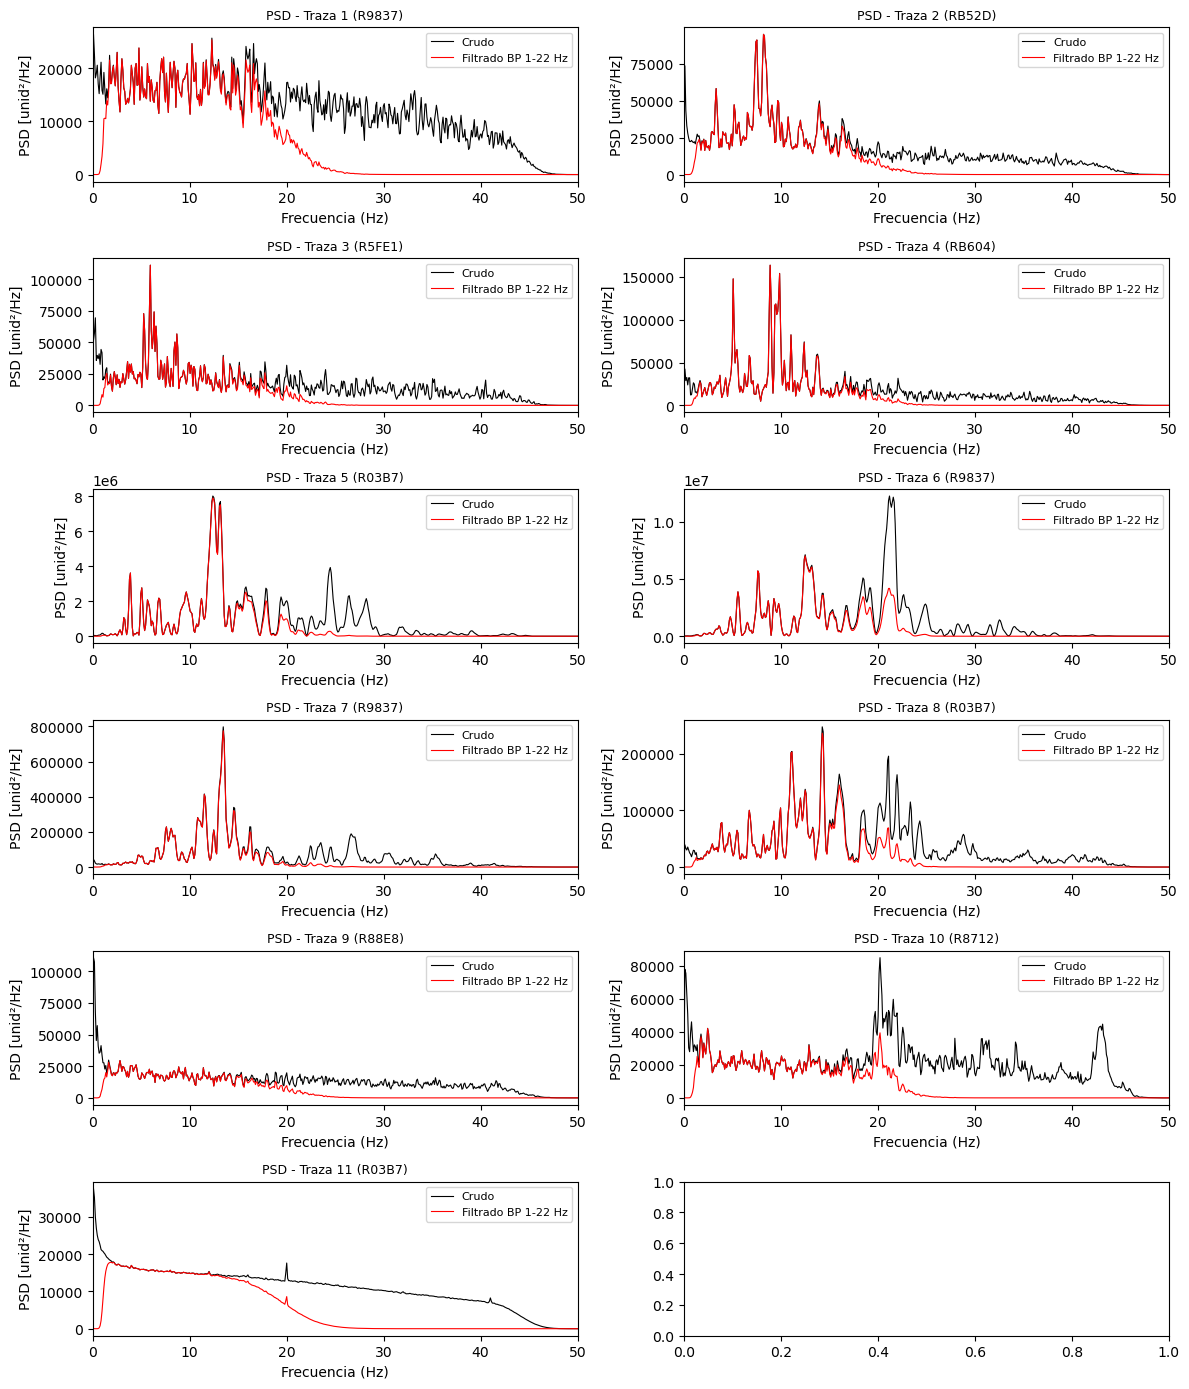

In [13]:
def bandpass_obspy(tr, fmin=1.0, fmax=22.0, order=3):
    tr_f = tr.copy()
    tr_f.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=order, zerophase=True)
    return tr_f

def psd_welch(x, fs, nperseg=1024):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, scaling="density")
    return f, Pxx

fig2, axes2 = plt.subplots(6, 2, figsize=(12, 14))
axes2 = axes2.flatten()

for i, tr in enumerate(trazas):
    f_raw, Pxx_raw = psd_welch(tr.data.astype(float), fs, nperseg=nperseg)
    trf = bandpass_obspy(tr, fmin=1.0, fmax=22.0, order=3)
    f_filt, Pxx_filt = psd_welch(trf.data.astype(float), fs, nperseg=nperseg)

    # Graficar ambas curvas
    axes2[i].plot(f_raw, Pxx_raw, color="black", linewidth=0.8, label="Crudo")
    axes2[i].plot(f_filt, Pxx_filt, color="red", linewidth=0.8, label="Filtrado BP 1-22 Hz")
    
    # Configuración de ejes
    axes2[i].set_xlim(0, fmax)
    axes2[i].set_title(f"PSD - Traza {i+1} ({getattr(tr.stats,'station','')})", fontsize=9)
    axes2[i].set_xlabel("Frecuencia (Hz)")
    axes2[i].set_ylabel("PSD [unid²/Hz]")
    axes2[i].legend(fontsize=8)

fig2.tight_layout()
plt.show()

## 5. Comparación de resultados

- Ahora aplicamos STA/LTA con los parámetros actuales del sistema de microsismos tanto para las señales crudas como filtradas y contabilizamos en ambos casos el número de falsas activaciones.

C:\Users\aisaa\AppData\Local\Temp\ipykernel_12420\3793023106.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(fontsize=7)
C:\Users\aisaa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


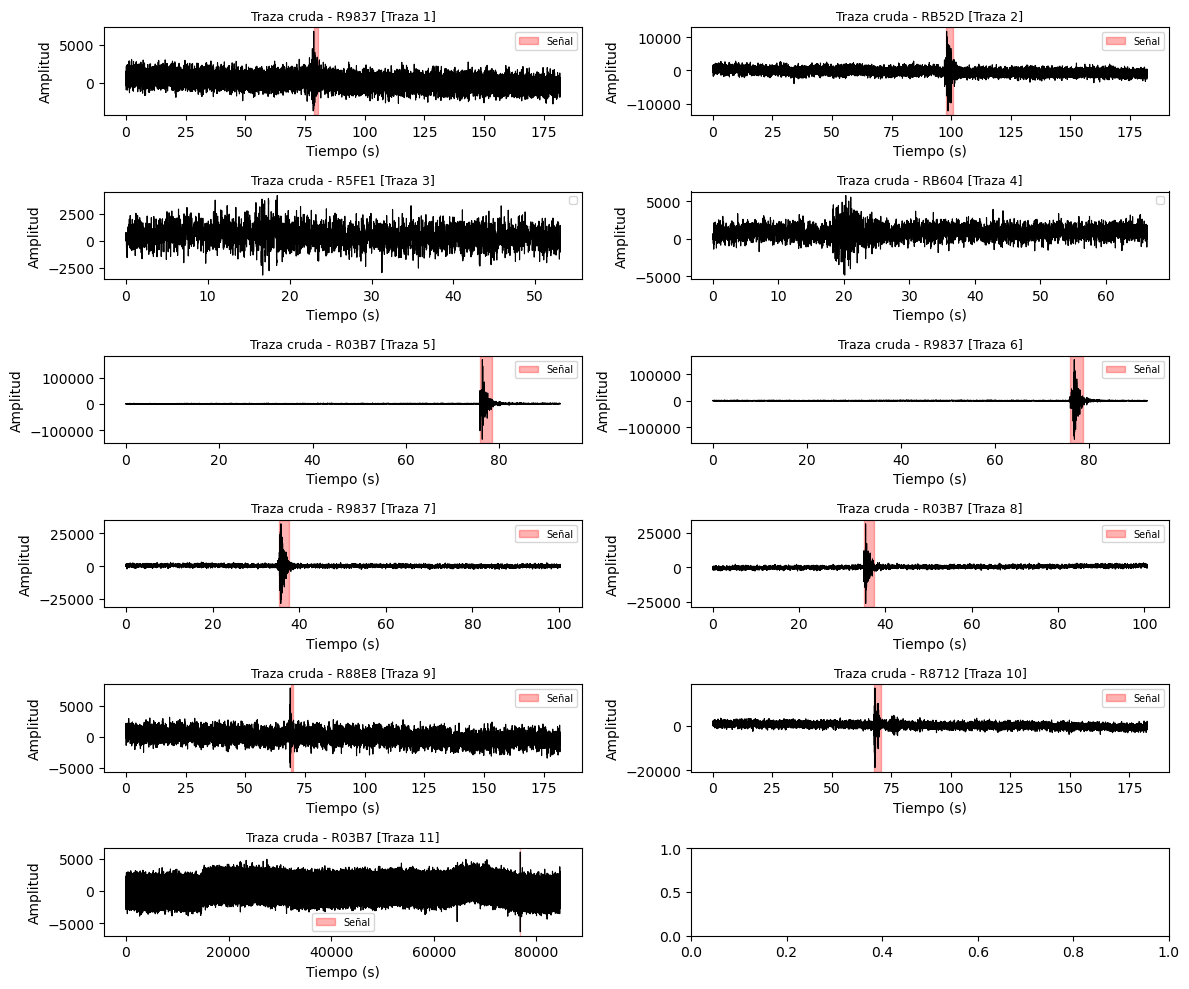

In [15]:
# Parámetros STA/LTA
nsta = int(1.0 * fs)   # ventana STA de 1 s
nlta = int(10.0 * fs)  # ventana LTA de 10 s
th_on = 3.4           # umbral de disparo
th_off = 0.8           # umbral de apagado

fig, axes = plt.subplots(6, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(11): 
    tr = trazas[i]
    data = tr.data.astype(float)

    # STA/LTA
    cft = classic_sta_lta(data, nsta, nlta)
    on_off = trigger_onset(cft, th_on, th_off)

    t = np.arange(0, len(data)) / fs
    axes[i].plot(t, data, color="black", linewidth=0.8)

    if len(on_off) > 0:
        on, off = on_off[0]
        axes[i].axvspan(on/fs, off/fs, color="red", alpha=0.3, label="Señal")

    axes[i].set_title(f"Traza cruda - {getattr(tr.stats,'station','')} [Traza {i+1}]",
                      fontsize=9)
    axes[i].set_xlabel("Tiempo (s)")
    axes[i].set_ylabel("Amplitud")
    axes[i].legend(fontsize=7)

fig.tight_layout()
plt.show()

### Tasa de error:
- 3 de 11 trazas = 27 %
### Tasa de éxito:
- 6 de 8 trazas = 75 %

C:\Users\aisaa\AppData\Local\Temp\ipykernel_12420\4128368938.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(fontsize=7)


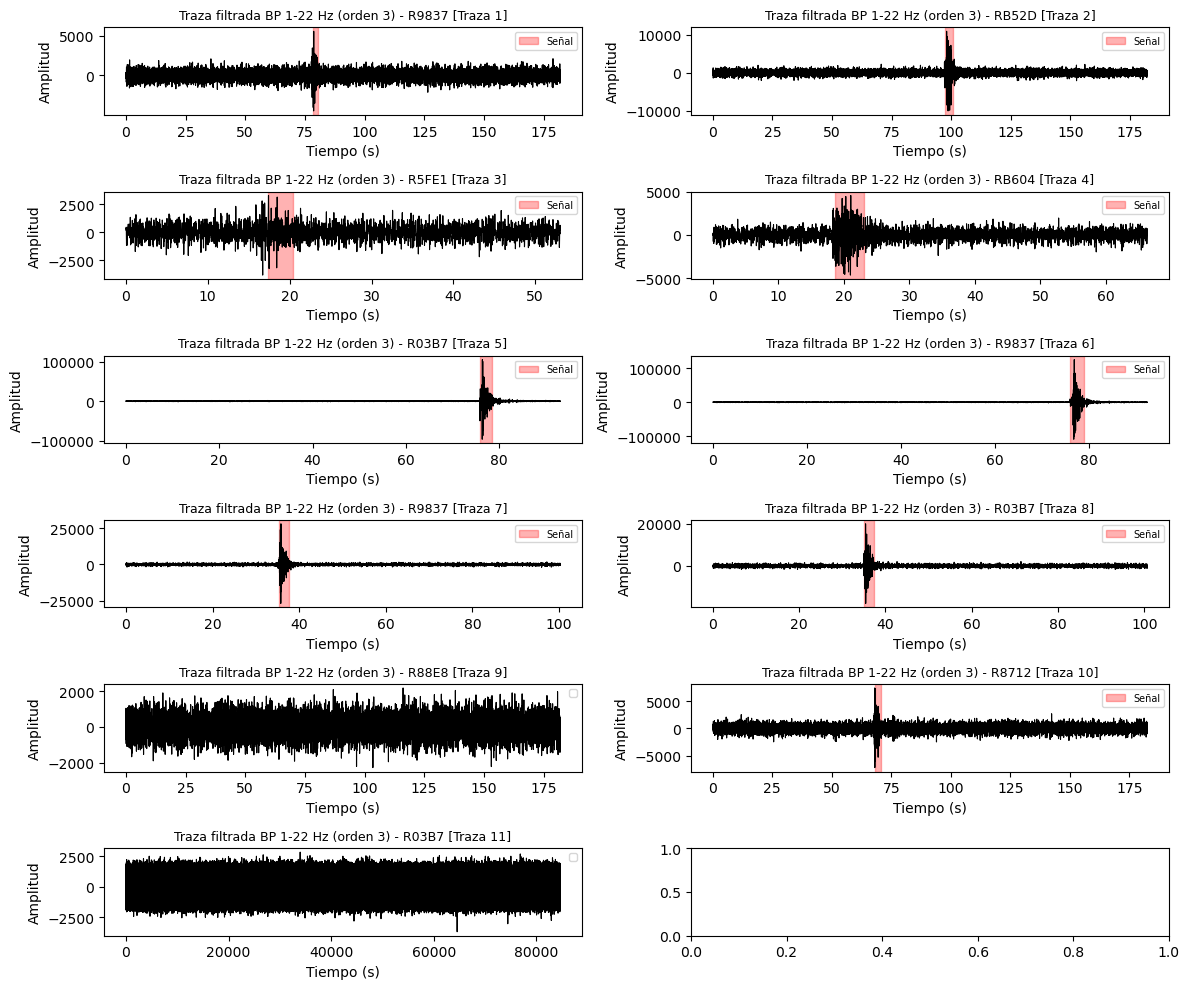

In [17]:
# Parámetros STA/LTA
nsta = int(1.0 * fs)   
nlta = int(10.0 * fs)  
th_on = 3.4            
th_off = 0.8           

fig, axes = plt.subplots(6, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(11): 
    tr = trazas[i]
    # Filtrado pasa-bandas
    trf = bandpass_obspy(tr, fmin=1.0, fmax=22.0, order=3)
    data = trf.data.astype(float)

    # STA/LTA
    cft = classic_sta_lta(data, nsta, nlta)
    on_off = trigger_onset(cft, th_on, th_off)

    t = np.arange(0, len(data)) / fs
    axes[i].plot(t, data, color="black", linewidth=0.8)

    if len(on_off) > 0:
        on, off = on_off[0]
        axes[i].axvspan(on/fs, off/fs, color="red", alpha=0.3, label="Señal")

    axes[i].set_title(f"Traza filtrada BP 1-22 Hz (orden 3) - {getattr(tr.stats,'station','')} [Traza {i+1}]",
                      fontsize=9)
    axes[i].set_xlabel("Tiempo (s)")
    axes[i].set_ylabel("Amplitud")
    axes[i].legend(fontsize=7)

fig.tight_layout()
plt.show()

### Tasa de error:
- 1 de 11 trazas = 9 %
### Tasa de éxito:
- 8 de 8 trazas = 100 %

## 10. Notas y recomendaciones
- Se recomienda aplicar este filtro como parte de la rutina de preprocesamiento previo a la transformada STA/LTA en el geófono vertical, ya que se observa un aumento considerable en la tasa de éxito para cazar microsismos (ejemplo trazas 3 y 4) las cuales antes del filtrado no eran reconocibles por el algoritmo de detección. Así mismo se llegó a una reducción de las falsas activaciones con una tasa de error del 9 %.


## Referencias breves
- Aki & Richards (2002). *Quantitative Seismology*.
- Sitio de **ObsPy**: documentación oficial y tutoriales.
